In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from default_func import extract_image_file_name_from_lidar_file_name, extract_bboxes_file_name_from_image_file_name

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
from os.path import join
import glob

root_path_train = '.\\camera_lidar_semantic_bboxes\\train\\'
# get the list of files in lidar directory
file_names_lidar_train = sorted(glob.glob(join(root_path_train, '*\\lidar\\cam_front_center\\*.npz')))

root_path_test = '.\\camera_lidar_semantic_bboxes\\test\\'
# get the list of files in lidar directory
file_names_lidar_test = sorted(glob.glob(join(root_path_test, '*\\lidar\\cam_front_center\\*.npz')))

file_names_photo_train = []

for file_name_lidar in file_names_lidar_train:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_train, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_train.append(file_name_image)

file_names_photo_test = []

for file_name_lidar in file_names_lidar_test:
    seq_name = file_name_lidar.split('\\')[3]
    file_name_image = extract_image_file_name_from_lidar_file_name(file_name_lidar)
    file_name_image = join(root_path_test, seq_name, 'camera\\cam_front_center\\', file_name_image)
    file_names_photo_test.append(file_name_image)

file_names_bboxes_train = []

for file_name_image, file_name_lidar in zip(file_names_photo_train, file_names_lidar_train):
    seq_name = file_name_lidar.split('\\')[3]
    file_name_bboxes = extract_bboxes_file_name_from_image_file_name(file_name_image)
    file_name_bboxes = join(root_path_train, seq_name, 'label3D\\cam_front_center\\', file_name_bboxes)
    file_names_bboxes_train.append(file_name_bboxes)

file_names_bboxes_test = []

for file_name_image, file_name_lidar in zip(file_names_photo_test, file_names_lidar_test):
    seq_name = file_name_lidar.split('\\')[3]
    file_name_bboxes = extract_bboxes_file_name_from_image_file_name(file_name_image)
    file_name_bboxes = join(root_path_test, seq_name, 'label3D\\cam_front_center\\', file_name_bboxes)
    file_names_bboxes_test.append(file_name_bboxes)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from default_func import read_bounding_boxes_2d

class DetectionDataset(Dataset):
    def __init__(self, image_files, bbox_files, image_size=(512, 512), output_format="DETR"):
        self.image_files = image_files
        self.bbox_files = bbox_files
        self.image_size = image_size
        self.output_format = output_format

        # Трансформации картинок
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),  # (0,1)
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # стандарт для DETR (ImageNet)
                                 std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Загружаем картинку
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")
        w, h = img.size  # исходный размер

        # Загружаем боксы
        target = read_bounding_boxes_2d(self.bbox_files[idx], (w, h), output_format=self.output_format)
        target['labels'] = target['labels'].to(device)
        target['boxes'] = target['boxes'].to(device)

        # Преобразуем картинку
        img = self.transform(img)


        return img, target


# collate_fn для DataLoader
def collate_fn(batch):
    images = [item[0] for item in batch]   # список тензоров картинок
    images = torch.stack(images, dim=0).to(device)
    targets = [item[1] for item in batch]  # список словарей с боксами
    return images, targets


# Пример использования
train_dataset = DetectionDataset(file_names_photo_train, file_names_bboxes_train, image_size=(322, 512))
test_dataset  = DetectionDataset(file_names_photo_test, file_names_bboxes_test, image_size=(322, 512))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


In [9]:
max_boxes = 0

for images, targets in train_loader:
    # print(len(images))        # batch_size
    # print(images[0].shape)    # torch.Size([3, H, W])
    # print(targets[0].keys())  # dict_keys(['boxes', 'labels'])
    # print(targets[0])

    for target in targets:
        # print(len(target['labels']))
        max_boxes = max(len(target['labels']), max_boxes)

for images, targets in test_loader:
    # print(len(images))        # batch_size
    # print(images[0].shape)    # torch.Size([3, H, W])
    # print(targets[0].keys())  # dict_keys(['boxes', 'labels'])
    # print(targets[0])

    for target in targets:
        # print(len(target['labels']))
        max_boxes = max(len(target['labels']), max_boxes)
        
print(max_boxes)

21


In [6]:
from HungrianLoss2D import HungarianMatcher, SetCriterion

# num_classes = число классов (без учёта no-object)
num_classes = 14
matcher = HungarianMatcher(cost_class=1, cost_bbox=5, cost_giou=2)
weight_dict = {'loss_ce': 1, 'loss_bbox': 5, 'loss_giou': 2}
criterion = SetCriterion(num_classes, matcher, weight_dict, eos_coef=0.1, losses=['labels', 'boxes'])


# Пример
outputs = {
    "pred_logits": torch.randn(2, 15, num_classes + 1),  # [batch=2, queries=15, classes+no_obj]
    "pred_boxes": torch.rand(2, 15, 4)                   # [cx,cy,w,h] нормализованные
}
targets = [
    {"labels": torch.tensor([0,2]), "boxes": torch.rand(2,4)},
    {"labels": torch.tensor([1]), "boxes": torch.rand(1,4)}
]

losses = criterion(outputs, targets)
print(losses)  # dict с loss_ce, loss_bbox, loss_giou (+ aux если есть)


{'loss_ce': tensor(3.0314), 'loss_bbox': tensor(2.3335), 'loss_giou': tensor(1.3181)}


In [6]:
from light_detr import LightweightDETR
from HungrianLoss2D import HungarianMatcher, SetCriterion

# ---- настройки ----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 6   # ТВОЙ случай: 14 реальных классов (фон не учитываем)
model = LightweightDETR(num_classes=num_classes,
                        num_queries=15,
                        hidden_dim=128,
                        nheads=4,
                        num_encoder_layers=2,
                        num_decoder_layers=2,
                        backbone_pretrained=True).to(device)

# criterion — используй SetCriterion, HungarianMatcher, как мы делали ранее
matcher = HungarianMatcher(cost_class=1, cost_bbox=5, cost_giou=2)
weight_dict = {'loss_ce': 1, 'loss_bbox': 5, 'loss_giou': 2}
criterion = SetCriterion(num_classes=num_classes, matcher=matcher, weight_dict=weight_dict, eos_coef=0.1, losses=['labels', 'boxes']).to(device)

C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


# Стандартные значения из оригинальной статьи:
model = DETR(
    backbone="resnet50",      # или resnet101
    hidden_dim=256,           # ✓ совпадает
    nheads=8,                 # 8 голов внимания
    num_encoder_layers=6,     # 6 энкодер layers
    num_decoder_layers=6,     # 6 декодер layers  
    num_queries=100,          # 100 object queries
    num_classes=91,           # COCO classes
    dropout=0.1,
    dim_feedforward=2048,     # FFN dimension
)

In [7]:
# оптимизатор с разным lr
backbone_params = [p for n, p in model.named_parameters() if 'backbone' in n and p.requires_grad]
other_params = [p for n, p in model.named_parameters() if 'backbone' not in n and p.requires_grad]
param_groups = [{'params': other_params, 'lr': 1e-4}, {'params': backbone_params, 'lr': 1e-5}]
optimizer = torch.optim.AdamW(param_groups, weight_decay=1e-4)

# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

model.to(device)
criterion.to(device)

SetCriterion(
  (matcher): HungarianMatcher()
)

In [8]:
num_epochs = 50  # можно начать с 10-20 для экспериментов
history_train = []
history_test = []

In [9]:
from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    # ---- ОБУЧЕНИЕ ----
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):

        # forward
        outputs = model(images)

        # считаем loss
        loss_dict = criterion(outputs, targets)
        weight_dict = criterion.weight_dict
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        # backward
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    avg_train_loss = total_loss / len(train_loader)
    history_train.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    # ---- ВАЛИДАЦИЯ ----
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for images, targets in test_loader:

            outputs = model(images)
            loss_dict = criterion(outputs, targets)
            weight_dict = criterion.weight_dict
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

            total_test_loss += losses.item()

    avg_test_loss = total_test_loss / len(test_loader)
    history_test.append(avg_test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {avg_test_loss:.4f}")

Epoch 1/50:   0%|          | 0/3059 [00:00<?, ?batch/s]c:\Users\neUral\anaconda3\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Epoch 1/50: 100%|██████████| 3059/3059 [21:22<00:00,  2.39batch/s]


Epoch 1/50, Train Loss: 12.8035
Epoch 1/50, Test Loss: 8.4183


Epoch 2/50: 100%|██████████| 3059/3059 [21:20<00:00,  2.39batch/s]


Epoch 2/50, Train Loss: 11.5085
Epoch 2/50, Test Loss: 8.3826


Epoch 3/50: 100%|██████████| 3059/3059 [21:19<00:00,  2.39batch/s]


Epoch 3/50, Train Loss: 10.9812
Epoch 3/50, Test Loss: 7.8131


Epoch 4/50: 100%|██████████| 3059/3059 [21:20<00:00,  2.39batch/s]


Epoch 4/50, Train Loss: 10.5866
Epoch 4/50, Test Loss: 7.1649


Epoch 5/50: 100%|██████████| 3059/3059 [21:20<00:00,  2.39batch/s]


Epoch 5/50, Train Loss: 10.1888
Epoch 5/50, Test Loss: 7.0164


Epoch 6/50: 100%|██████████| 3059/3059 [21:20<00:00,  2.39batch/s]


Epoch 6/50, Train Loss: 9.7639
Epoch 6/50, Test Loss: 6.2801


Epoch 7/50: 100%|██████████| 3059/3059 [20:53<00:00,  2.44batch/s]


Epoch 7/50, Train Loss: 9.4544
Epoch 7/50, Test Loss: 6.4998


Epoch 8/50: 100%|██████████| 3059/3059 [20:04<00:00,  2.54batch/s]


Epoch 8/50, Train Loss: 9.1771
Epoch 8/50, Test Loss: 6.1147


Epoch 9/50: 100%|██████████| 3059/3059 [20:01<00:00,  2.55batch/s]


Epoch 9/50, Train Loss: 9.0195
Epoch 9/50, Test Loss: 6.1143


Epoch 10/50: 100%|██████████| 3059/3059 [20:03<00:00,  2.54batch/s]


Epoch 10/50, Train Loss: 8.8121
Epoch 10/50, Test Loss: 5.9863


Epoch 11/50: 100%|██████████| 3059/3059 [20:02<00:00,  2.54batch/s]


Epoch 11/50, Train Loss: 8.7087
Epoch 11/50, Test Loss: 5.5886


Epoch 12/50: 100%|██████████| 3059/3059 [20:05<00:00,  2.54batch/s]


Epoch 12/50, Train Loss: 8.6013
Epoch 12/50, Test Loss: 5.7112


Epoch 13/50: 100%|██████████| 3059/3059 [20:01<00:00,  2.55batch/s]


Epoch 13/50, Train Loss: 8.3933
Epoch 13/50, Test Loss: 5.9355


Epoch 14/50: 100%|██████████| 3059/3059 [20:11<00:00,  2.53batch/s]


Epoch 14/50, Train Loss: 8.3708
Epoch 14/50, Test Loss: 5.6868


Epoch 15/50: 100%|██████████| 3059/3059 [20:18<00:00,  2.51batch/s]


Epoch 15/50, Train Loss: 8.2271
Epoch 15/50, Test Loss: 5.4894


Epoch 16/50: 100%|██████████| 3059/3059 [20:24<00:00,  2.50batch/s]


Epoch 16/50, Train Loss: 8.1192
Epoch 16/50, Test Loss: 5.7247


Epoch 17/50: 100%|██████████| 3059/3059 [20:19<00:00,  2.51batch/s]


Epoch 17/50, Train Loss: 8.0269
Epoch 17/50, Test Loss: 5.3528


Epoch 18/50: 100%|██████████| 3059/3059 [20:16<00:00,  2.51batch/s]


Epoch 18/50, Train Loss: 8.0478
Epoch 18/50, Test Loss: 5.3286


Epoch 19/50: 100%|██████████| 3059/3059 [20:17<00:00,  2.51batch/s]


Epoch 19/50, Train Loss: 7.9615
Epoch 19/50, Test Loss: 5.6838


Epoch 20/50: 100%|██████████| 3059/3059 [20:15<00:00,  2.52batch/s]


Epoch 20/50, Train Loss: 7.8604
Epoch 20/50, Test Loss: 5.6041


Epoch 21/50: 100%|██████████| 3059/3059 [20:16<00:00,  2.51batch/s]


Epoch 21/50, Train Loss: 7.7803
Epoch 21/50, Test Loss: 5.3194


Epoch 22/50: 100%|██████████| 3059/3059 [20:18<00:00,  2.51batch/s]


Epoch 22/50, Train Loss: 7.6996
Epoch 22/50, Test Loss: 5.3365


Epoch 23/50: 100%|██████████| 3059/3059 [20:20<00:00,  2.51batch/s]


Epoch 23/50, Train Loss: 7.6928
Epoch 23/50, Test Loss: 5.1210


Epoch 24/50: 100%|██████████| 3059/3059 [20:20<00:00,  2.51batch/s]


Epoch 24/50, Train Loss: 7.5960
Epoch 24/50, Test Loss: 5.2707


Epoch 25/50: 100%|██████████| 3059/3059 [20:22<00:00,  2.50batch/s]


Epoch 25/50, Train Loss: 7.5864
Epoch 25/50, Test Loss: 5.1532


Epoch 26/50: 100%|██████████| 3059/3059 [20:19<00:00,  2.51batch/s]


Epoch 26/50, Train Loss: 7.5603
Epoch 26/50, Test Loss: 5.2755


Epoch 27/50: 100%|██████████| 3059/3059 [20:19<00:00,  2.51batch/s]


Epoch 27/50, Train Loss: 7.5030
Epoch 27/50, Test Loss: 5.2863


Epoch 28/50: 100%|██████████| 3059/3059 [20:21<00:00,  2.50batch/s]


Epoch 28/50, Train Loss: 7.4902
Epoch 28/50, Test Loss: 5.2349


Epoch 29/50: 100%|██████████| 3059/3059 [20:22<00:00,  2.50batch/s]


Epoch 29/50, Train Loss: 7.3671
Epoch 29/50, Test Loss: 5.3231


Epoch 30/50: 100%|██████████| 3059/3059 [20:19<00:00,  2.51batch/s]


Epoch 30/50, Train Loss: 7.3586
Epoch 30/50, Test Loss: 5.1267


Epoch 31/50: 100%|██████████| 3059/3059 [20:20<00:00,  2.51batch/s]


Epoch 31/50, Train Loss: 7.4900
Epoch 31/50, Test Loss: 5.3110


Epoch 32/50: 100%|██████████| 3059/3059 [20:18<00:00,  2.51batch/s]


Epoch 32/50, Train Loss: 7.3130
Epoch 32/50, Test Loss: 5.0351


Epoch 33/50: 100%|██████████| 3059/3059 [20:20<00:00,  2.51batch/s]


Epoch 33/50, Train Loss: 7.2699
Epoch 33/50, Test Loss: 5.1954


Epoch 34/50: 100%|██████████| 3059/3059 [20:17<00:00,  2.51batch/s]


Epoch 34/50, Train Loss: 7.2625
Epoch 34/50, Test Loss: 5.3952


Epoch 35/50: 100%|██████████| 3059/3059 [20:20<00:00,  2.51batch/s]


Epoch 35/50, Train Loss: 7.2137
Epoch 35/50, Test Loss: 5.0882


Epoch 36/50: 100%|██████████| 3059/3059 [20:20<00:00,  2.51batch/s]


Epoch 36/50, Train Loss: 7.2213
Epoch 36/50, Test Loss: 5.2663


Epoch 37/50: 100%|██████████| 3059/3059 [20:18<00:00,  2.51batch/s]


Epoch 37/50, Train Loss: 7.2379
Epoch 37/50, Test Loss: 5.3298


Epoch 38/50: 100%|██████████| 3059/3059 [20:15<00:00,  2.52batch/s]


Epoch 38/50, Train Loss: 7.1386
Epoch 38/50, Test Loss: 5.1627


Epoch 39/50: 100%|██████████| 3059/3059 [20:17<00:00,  2.51batch/s]


Epoch 39/50, Train Loss: 7.1012
Epoch 39/50, Test Loss: 5.1215


Epoch 40/50: 100%|██████████| 3059/3059 [20:19<00:00,  2.51batch/s]


Epoch 40/50, Train Loss: 7.1040
Epoch 40/50, Test Loss: 5.0528


Epoch 41/50: 100%|██████████| 3059/3059 [20:17<00:00,  2.51batch/s]


Epoch 41/50, Train Loss: 7.0989
Epoch 41/50, Test Loss: 5.1866


Epoch 42/50: 100%|██████████| 3059/3059 [20:20<00:00,  2.51batch/s]


Epoch 42/50, Train Loss: 7.0996
Epoch 42/50, Test Loss: 5.3278


Epoch 43/50: 100%|██████████| 3059/3059 [20:17<00:00,  2.51batch/s]


Epoch 43/50, Train Loss: 7.0770
Epoch 43/50, Test Loss: 5.1524


Epoch 44/50: 100%|██████████| 3059/3059 [20:19<00:00,  2.51batch/s]


Epoch 44/50, Train Loss: 7.1197
Epoch 44/50, Test Loss: 5.1461


Epoch 45/50: 100%|██████████| 3059/3059 [20:20<00:00,  2.51batch/s]


Epoch 45/50, Train Loss: 7.0553
Epoch 45/50, Test Loss: 5.1810


Epoch 46/50: 100%|██████████| 3059/3059 [20:18<00:00,  2.51batch/s]


Epoch 46/50, Train Loss: 7.0858
Epoch 46/50, Test Loss: 5.1073


Epoch 47/50: 100%|██████████| 3059/3059 [20:15<00:00,  2.52batch/s]


Epoch 47/50, Train Loss: 7.0917
Epoch 47/50, Test Loss: 5.1491


Epoch 48/50: 100%|██████████| 3059/3059 [20:18<00:00,  2.51batch/s]


Epoch 48/50, Train Loss: 6.9447
Epoch 48/50, Test Loss: 5.2883


Epoch 49/50: 100%|██████████| 3059/3059 [20:18<00:00,  2.51batch/s]


Epoch 49/50, Train Loss: 6.9587
Epoch 49/50, Test Loss: 5.0253


Epoch 50/50: 100%|██████████| 3059/3059 [20:15<00:00,  2.52batch/s]


Epoch 50/50, Train Loss: 6.8985
Epoch 50/50, Test Loss: 4.9974


In [46]:
import torch
import torch.nn.functional as F
from torchvision.ops import nms

def postprocess(outputs, threshold=0.7):
    """
    outputs: dict с ключами 'pred_logits' и 'pred_boxes'
        pred_logits: [batch_size, num_queries, num_classes+1]
        pred_boxes: [batch_size, num_queries, 4]
    """
    pred_logits = outputs['pred_logits']  # [B, Q, C+1]
    pred_boxes = outputs['pred_boxes']    # [B, Q, 4]

    probs = F.softmax(pred_logits, -1)        # вероятности по классам
    scores, labels = probs[..., :-1].max(-1)  # игнорируем "no-object" (последний класс)

    results = []
    for b in range(pred_logits.shape[0]):
        keep = scores[b] > threshold
        boxes = pred_boxes[b][keep]
        clses = labels[b][keep]
        scrs = scores[b][keep]

        results.append({
            "boxes": boxes.detach().cpu(),
            "labels": clses.detach().cpu(),
            "scores": scrs.detach().cpu()
        })
    return results

def postprocess_with_nms(outputs, threshold=0.7, nms_threshold=0.5):
    """
    outputs: dict с ключами 'pred_logits' и 'pred_boxes'
        pred_logits: [batch_size, num_queries, num_classes+1]
        pred_boxes: [batch_size, num_queries, 4]
    threshold: порог уверенности для фильтрации предсказаний
    nms_threshold: порог IoU для NMS
    """
    pred_logits = outputs['pred_logits']  # [B, Q, C+1]
    pred_boxes = outputs['pred_boxes']    # [B, Q, 4]

    probs = F.softmax(pred_logits, -1)        # вероятности по классам
    scores, labels = probs[..., :-1].max(-1)  # игнорируем "no-object" (последний класс)

    results = []
    for b in range(pred_logits.shape[0]):
        # Первоначальная фильтрация по порогу уверенности
        keep = scores[b] > threshold
        boxes = pred_boxes[b][keep]
        clses = labels[b][keep]
        scrs = scores[b][keep]
        
        # Если нет детекций после фильтрации по порогу
        if len(boxes) == 0:
            results.append({
                "boxes": torch.empty((0, 4)),
                "labels": torch.empty((0,), dtype=torch.long),
                "scores": torch.empty((0,))
            })
            continue
        
        # Применяем NMS для каждого класса отдельно
        keep_indices = []
        
        # Получаем уникальные классы
        unique_classes = clses.unique()
        
        for cls in unique_classes:
            # Маска для текущего класса
            cls_mask = (clses == cls)
            
            # Если нет детекций этого класса, пропускаем
            if not cls_mask.any():
                continue
            
            # Боксы и скоры текущего класса
            cls_boxes = boxes[cls_mask]
            cls_scores = scrs[cls_mask]
            
            # Преобразуем YOLO формат [x_center, y_center, width, height] 
            # в формат [x1, y1, x2, y2] для NMS
            x_center, y_center, width, height = cls_boxes.t()
            x1 = x_center - width / 2
            y1 = y_center - height / 2
            x2 = x_center + width / 2
            y2 = y_center + height / 2
            cls_boxes_xyxy = torch.stack([x1, y1, x2, y2], dim=1)
            
            # Применяем NMS для текущего класса
            nms_indices = nms(cls_boxes_xyxy, cls_scores, nms_threshold)
            
            # Сохраняем индексы с учетом исходной маски класса
            original_indices = torch.where(cls_mask)[0][nms_indices]
            keep_indices.append(original_indices)
        
        # Объединяем результаты NMS для всех классов
        if keep_indices:
            keep_indices = torch.cat(keep_indices)
        else:
            keep_indices = torch.tensor([], dtype=torch.long)
        
        # Сортируем по убыванию уверенности
        if len(keep_indices) > 0:
            sorted_indices = torch.argsort(scrs[keep_indices], descending=True)
            keep_indices = keep_indices[sorted_indices]
        
        results.append({
            "boxes": boxes[keep_indices].detach().cpu(),
            "labels": clses[keep_indices].detach().cpu(),
            "scores": scrs[keep_indices].detach().cpu()
        })
    
    return results

In [11]:
import cv2

def draw_2d_boxes_YOLO(image_tensor, boxes_2d, groubd_truth_boxes, image_size=(322, 512), img_name = 'test_image.png', save = True):
    image_height = image_size[0]
    image_width = image_size[1]
    # Конвертируем тензор в numpy array для OpenCV
    # Предполагаем, что тензор в формате [C, H, W] и нормализован
    image = image_tensor.cpu().numpy()
    
    # Транспонируем из [C, H, W] в [H, W, C]
    image = np.transpose(image, (1, 2, 0))
    
    # Денормализуем, если изображение было нормализовано
    # (предполагаем, что нормализация была mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    
    # Конвертируем RGB в BGR для OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    boxes = boxes_2d['boxes'].cpu().numpy()
    labels = boxes_2d['labels'].cpu().numpy()

    boxes_GT = groubd_truth_boxes['boxes'].cpu().numpy()
    labels_GT = groubd_truth_boxes['labels'].cpu().numpy()


    
    for box, label in zip(boxes, labels):
        if label == 0:
            continue

        # Получаем нормализованные координаты YOLO
        x_center_norm = box[0]
        y_center_norm = box[1]
        width_norm = box[2]
        height_norm = box[3]
        
        # Преобразуем нормализованные координаты в абсолютные пиксели
        x_center = x_center_norm * image_width
        y_center = y_center_norm * image_height
        bbox_width = width_norm * image_width
        bbox_height = height_norm * image_height
        
        # Конвертируем из center+size в top-left + bottom-right
        left = int(x_center - bbox_width / 2)
        top = int(y_center - bbox_height / 2)
        right = int(x_center + bbox_width / 2)
        bottom = int(y_center + bbox_height / 2)
        
        # Проверяем валидность координат
        left = max(0, min(left, image_width - 1))
        top = max(0, min(top, image_height - 1))
        right = max(0, min(right, image_width - 1))
        bottom = max(0, min(bottom, image_height - 1))
        
        # Отрисовка 2D-баундинг-бокса
        cv2.rectangle(image, (top, left), (bottom, right), [255, 0, 0], 2)  # Исправлены координаты

    for box, label in zip(boxes_GT, labels_GT):
        if label == 0:
            continue

        # Получаем нормализованные координаты YOLO
        x_center_norm = box[0]
        y_center_norm = box[1]
        width_norm = box[2]
        height_norm = box[3]
        
        # Преобразуем нормализованные координаты в абсолютные пиксели
        x_center = x_center_norm * image_width
        y_center = y_center_norm * image_height
        bbox_width = width_norm * image_width
        bbox_height = height_norm * image_height
        
        # Конвертируем из center+size в top-left + bottom-right
        left = int(x_center - bbox_width / 2)
        top = int(y_center - bbox_height / 2)
        right = int(x_center + bbox_width / 2)
        bottom = int(y_center + bbox_height / 2)
        
        # Проверяем валидность координат
        left = max(0, min(left, image_width - 1))
        top = max(0, min(top, image_height - 1))
        right = max(0, min(right, image_width - 1))
        bottom = max(0, min(bottom, image_height - 1))
        
        # Отрисовка 2D-баундинг-бокса
        cv2.rectangle(image, (top, left), (bottom, right), [0, 255, 0], 2)  # Исправлены координаты

    # Конвертируем обратно в RGB для matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Отображаем результат
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    if save: 
        plt.savefig(f'{img_name}')

In [12]:
checkpoint = torch.load('.\\models\\pitstop_DETR2D_6_classes.pth', map_location=device)
    
# Загружаем состояние модели
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

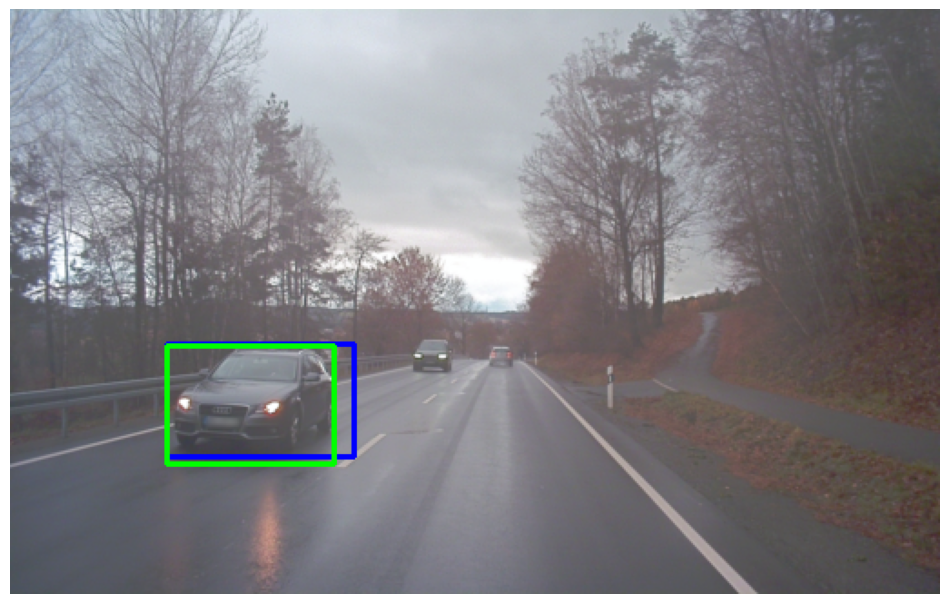

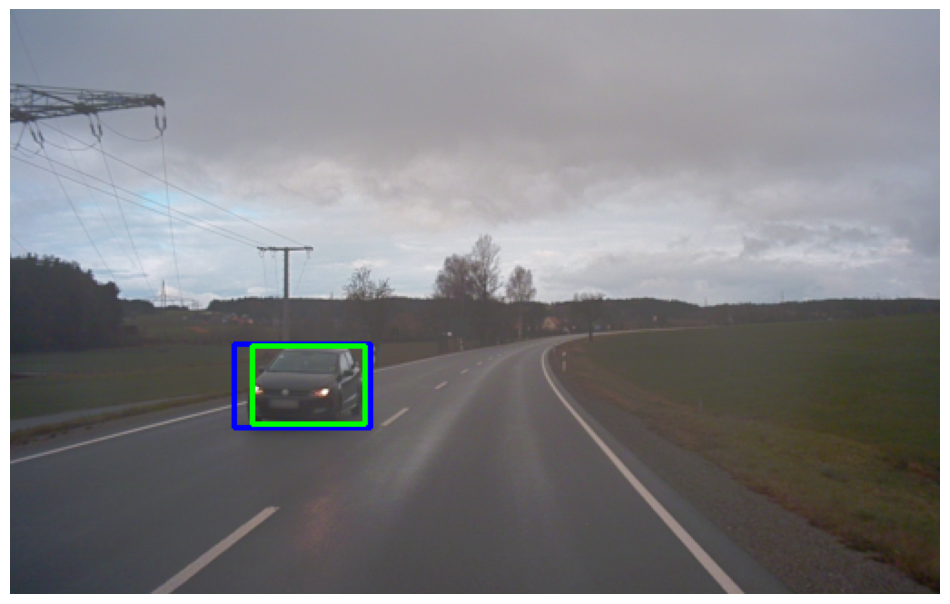

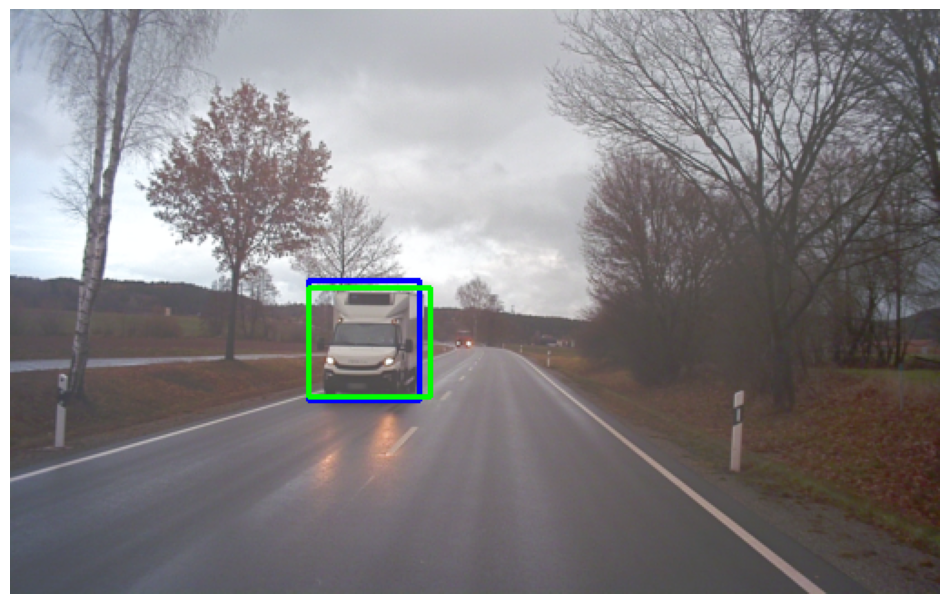

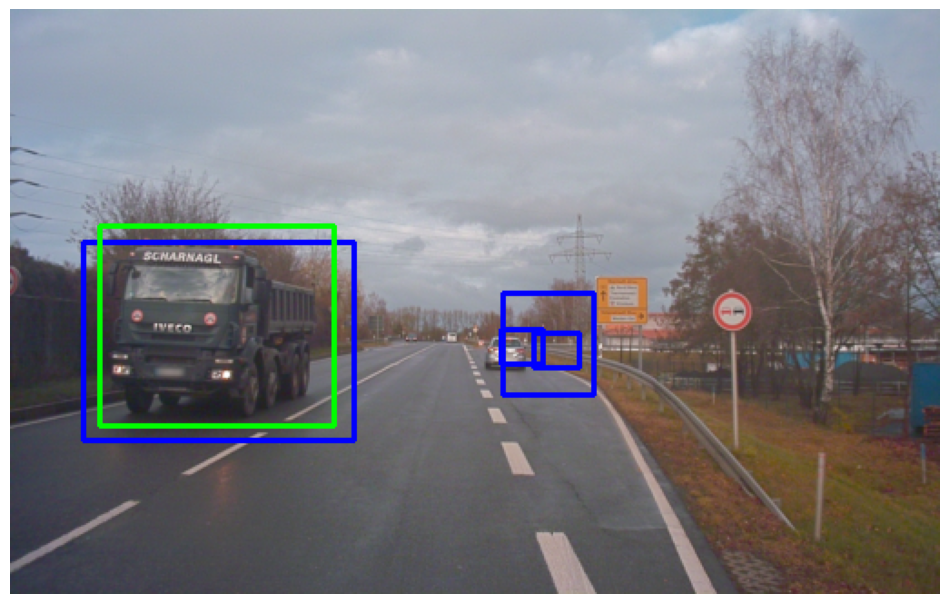

In [50]:
num = 0
# проход по тестовому датасету
model.eval()
with torch.no_grad():
    for images, targets in test_loader:

        outputs = model(images)

        # переводим в формат как в targets (списки словарей)
        preds = postprocess_with_nms(outputs, threshold=0.5, nms_threshold=0.5)

        for imgs, pred, target in zip(images, preds, targets):
            draw_2d_boxes_YOLO(imgs, pred, target, image_size=(322, 512), img_name=f'.\\tests\\DETR2D\\test_image_{num}.png', save = False )
            num +=1
            
        break   

In [47]:
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as Func

def yolo_to_xyxy(boxes):

    image_width = 512
    image_height = 332

    ans = []

    for box in boxes:
        # Получаем нормализованные координаты YOLO
        x_center_norm = box[0]
        y_center_norm = box[1]
        width_norm = box[2]
        height_norm = box[3]

        # Преобразуем нормализованные координаты в абсолютные пиксели
        x_center = x_center_norm * image_width
        y_center = y_center_norm * image_height
        bbox_width = width_norm * image_width
        bbox_height = height_norm * image_height

        # Конвертируем из center+size в top-left + bottom-right
        left = int(x_center - bbox_width / 2)
        top = int(y_center - bbox_height / 2)
        right = int(x_center + bbox_width / 2)
        bottom = int(y_center + bbox_height / 2)

        # Проверяем валидность координат
        left = max(0, min(left, image_width - 1))
        top = max(0, min(top, image_height - 1))
        right = max(0, min(right, image_width - 1))
        bottom = max(0, min(bottom, image_height - 1))

        ans.append([top, left, bottom, right])


    return torch.FloatTensor(ans)

def visualize_batch_ssd(images, targets, class_names=None):
    batch_size = images.shape[0]  # Количество изображений в батче
    
    
    # ImageNet стандартные параметры нормализации
    IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
    IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])
    
    batch_size = images.shape[0]
    
    for i in range(batch_size):
        # Денормализуем ImageNet
        img = images[i].cpu().clone()
        
        # Денормализация: image = (image * std) + mean
        for c in range(3):
            img[c] = img[c] * IMAGENET_STD[c] + IMAGENET_MEAN[c]
        
        # Обрезаем значения в диапазон [0, 1]
        img = torch.clamp(img, 0, 1)
        
        # Преобразуем в [0, 255] для визуализации
        img = (img * 255).byte()
        
        target = targets[i]
        boxes = target['boxes'].cpu().int()  # Достаем координаты боксов
        labels = target['labels'].cpu().tolist()  # Достаем метки классов
        scores = target['scores'].cpu().tolist()  # Достаем вероятности
        
        # Генерируем текстовые метки с учетом имен классов
        if class_names:
            labels = [f"{class_names[label]}: {score:.2f}" for label, score in zip(labels, scores)]
        else:
            labels = [f"{label}: {score:.2f}" for label, score in zip(labels, scores)]
        
        img = draw_bounding_boxes(img, boxes, labels=labels, colors="red", width=2)
        
        plt.figure(figsize=(6, 6))
        img = Func.to_pil_image(img)
        plt.imshow(img)
        plt.axis("off")
        plt.show()

In [55]:


def visualize_batch_ssd_with_GT(images, targets, ground_truth, class_names=None, img_name = 'test_image', save = False):
    batch_size = images.shape[0]  # Количество изображений в батче
    
    
    # ImageNet стандартные параметры нормализации
    IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406])
    IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225])
    
    batch_size = images.shape[0]
    
    for i in range(batch_size):
        # Денормализуем ImageNet
        img = images[i].cpu().clone()
        
        # Денормализация: image = (image * std) + mean
        for c in range(3):
            img[c] = img[c] * IMAGENET_STD[c] + IMAGENET_MEAN[c]
        
        # Обрезаем значения в диапазон [0, 1]
        img = torch.clamp(img, 0, 1)
        
        # Преобразуем в [0, 255] для визуализации
        img = (img * 255).byte()
        
        target = targets[i]
        boxes = target['boxes'].cpu().int()  # Достаем координаты боксов
        labels = target['labels'].cpu().tolist()  # Достаем метки классов
        scores = target['scores'].cpu().tolist()  # Достаем вероятности

        gt = ground_truth[i]
        boxes_gt = gt['boxes'].cpu().int()  # Достаем координаты боксов
        labels_gt = gt['labels'].cpu().tolist()  # Достаем метки классов
        scores_gt = gt['scores'].cpu().tolist()  # Достаем вероятности
        
        # Генерируем текстовые метки с учетом имен классов
        if class_names:
            labels = [f"{class_names[label]}: {score:.2f}" for label, score in zip(labels, scores)]
        else:
            labels = [f"{label}: {score:.2f}" for label, score in zip(labels, scores)]

        if class_names:
            labels_gt = [f"{class_names[label]}: {score:.2f}" for label, score in zip(labels_gt, scores_gt)]
        else:
            labels_gt = [f"{label}: {score:.2f}" for label, score in zip(labels_gt, scores_gt)]

        img = draw_bounding_boxes(img, boxes_gt, labels=labels_gt, colors="green", width=2)
        img = draw_bounding_boxes(img, boxes, labels=labels, colors="red", width=2)
        
        plt.figure(figsize=(6, 6))
        img = Func.to_pil_image(img)
        plt.imshow(img)
        plt.axis("off")
        if save: 
            plt.savefig(f'{img_name}_{i}.png')
        else:
            plt.show()

  0%|          | 0/66 [00:00<?, ?it/s]

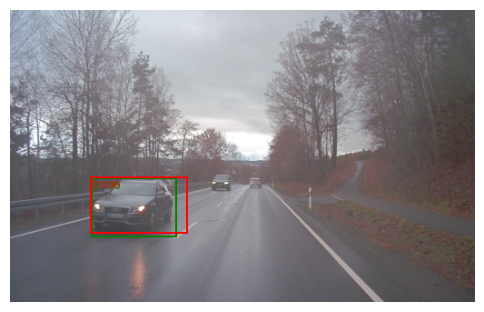

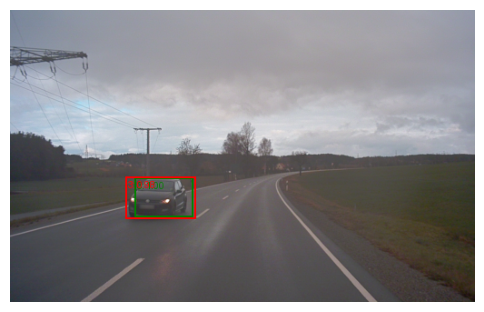

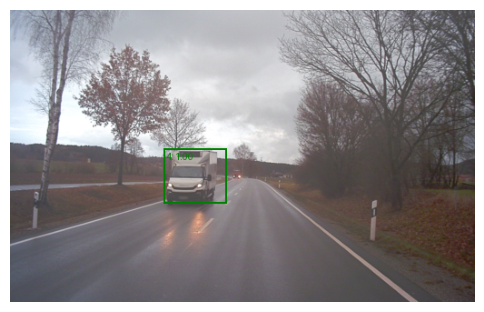

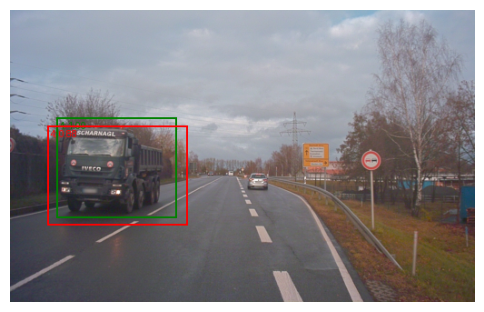

  0%|          | 0/66 [00:00<?, ?it/s]


In [58]:
from tqdm import tqdm

model.eval()
with torch.no_grad():
    for images_test, targets_test in tqdm(test_loader):
        outputs = model(images_test)
        preds = postprocess_with_nms(outputs, threshold=0.8, nms_threshold=0.5)

        # preds уже список словарей: [{'boxes':..., 'labels':..., 'scores':...}, ...]
        # targets_test — список словарей: [{'boxes':..., 'labels':...}, ...]

        for pred, target in zip(preds, targets_test):
            target['boxes'] = yolo_to_xyxy(target['boxes'].cpu().numpy())
            target['labels'] = target['labels'].cpu()
            pred['boxes'] = yolo_to_xyxy(pred['boxes'].cpu().numpy())
            n = len(target['labels'])
            target['scores'] = torch.ones(n, dtype=torch.float32)

        
        #visualize_batch_ssd(images_test, preds, class_names=None)
        visualize_batch_ssd_with_GT(images, preds, targets_test, class_names=None, img_name = 'test_image', save = False)

        
        break

In [39]:
from tqdm import tqdm

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for images_test, targets_test in tqdm(test_loader):
        outputs = model(images_test)
        preds = postprocess_with_nms(outputs, threshold=0.9, nms_threshold=0.5)

        # preds уже список словарей: [{'boxes':..., 'labels':..., 'scores':...}, ...]
        # targets_test — список словарей: [{'boxes':..., 'labels':...}, ...]

        for pred, target in zip(preds, targets_test):
            target['boxes'] = yolo_to_xyxy(target['boxes'].cpu().numpy())
            target['labels'] = target['labels'].cpu()
            pred['boxes'] = yolo_to_xyxy(pred['boxes'].cpu().numpy())


        all_preds.extend(preds)
        all_targets.extend(targets_test)

100%|██████████| 66/66 [00:21<00:00,  3.14it/s]


In [59]:
import torch
import numpy as np
from collections import defaultdict
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt


def box_iou(boxes1, boxes2):
    area1 = (boxes1[:, 2] - boxes1[:, 0]).clamp(min=0) * (boxes1[:, 3] - boxes1[:, 1]).clamp(min=0)
    area2 = (boxes2[:, 2] - boxes2[:, 0]).clamp(min=0) * (boxes2[:, 3] - boxes2[:, 1]).clamp(min=0)

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  

    wh = (rb - lt).clamp(min=0)  
    inter = wh[..., 0] * wh[..., 1]  

    union = area1[:, None] + area2 - inter
    return inter / union.clamp(min=1e-6)


def collect_class_detections(all_preds, all_targets, class_id, iou_threshold=0.5):
    y_true, y_scores = [], []

    for pred, target in zip(all_preds, all_targets):
        preds_cls = pred['labels'] == class_id
        boxes_pred = pred['boxes'][preds_cls]
        scores_pred = pred['scores'][preds_cls]

        gts_cls = target['labels'] == class_id
        boxes_gt = target['boxes'][gts_cls]

        matched_gt = set()
        for box, score in zip(boxes_pred, scores_pred):
            if len(boxes_gt) > 0:
                ious = box_iou(box.unsqueeze(0), boxes_gt).squeeze(0)
                best_iou, idx = ious.max(0)
                if best_iou >= iou_threshold and idx.item() not in matched_gt:
                    y_true.append(1)
                    matched_gt.add(idx.item())
                else:
                    y_true.append(0)
            else:
                y_true.append(0)

            y_scores.append(score.item())

        # FN для оставшихся GT
        for _ in range(len(boxes_gt) - len(matched_gt)):
            y_true.append(1)
            y_scores.append(0.0)

    return np.array(y_true), np.array(y_scores)


def evaluate_map(all_preds, all_targets, class_ids, iou_threshold=0.5, plot_classes=None):
    aps = {}
    pr_curves = {}  # тут будем хранить кривые: {class_id: (precision, recall)}

    for cid in class_ids:
        y_true, y_scores = collect_class_detections(all_preds, all_targets, cid, iou_threshold)

        if len(np.unique(y_true)) < 2:
            continue

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        ap = auc(recall, precision)
        aps[cid] = ap
        pr_curves[cid] = (precision, recall)

        if plot_classes and cid in plot_classes:
            plt.plot(recall, precision, label=f"Class {cid} (AP={ap:.3f})")

    if plot_classes:
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall curves")
        plt.legend()
        plt.grid()
        plt.show()

    mAP = np.mean(list(aps.values())) if aps else 0.0
    return mAP, aps, pr_curves


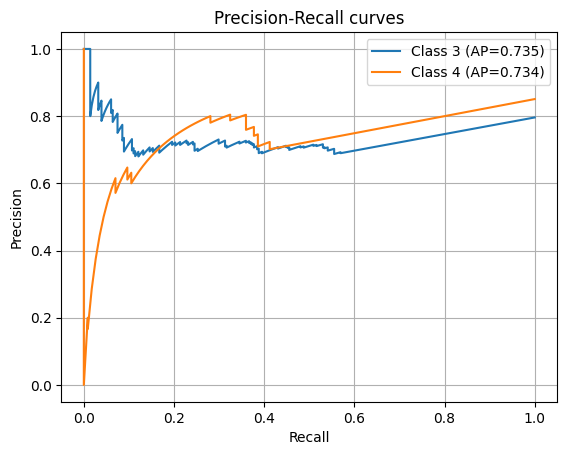

mAP: 0.7348190158503778
APs по классам: {3: 0.735412070785632, 4: 0.7342259609151236}


In [62]:
# После инференса (как у тебя в коде):
# all_preds, all_targets собраны

class_ids = [3, 4]   # интересующие классы
mAP, aps, pr = evaluate_map(all_preds, all_targets, class_ids, iou_threshold=0.5, plot_classes=[3, 4])

print("mAP:", mAP)
print("APs по классам:", aps)


In [63]:
np.savez(".\\results_2d_detection\\pr_curves\\pr_curves_DETR.npz", **{str(k): v for k,v in pr.items()})

In [13]:
checkpoint = {
    'epoch': epoch,  # количество выполненных эпох
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': losses,  # значение функции потерь
    # можно добавлять и другие метрики, нужные для ваших экспериментов
}
torch.save(checkpoint, '.\\models\\pitstop_DETR2D_6_classes.pth')